In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
#DOS STUFF

@njit
def get_random_vector_dos(size):
    return np.exp(-2*np.pi*np.random.random(size)*1j).astype(np.cdouble)/np.sqrt(size)

@njit
def hamiltonian_vector_product(vector, W_vector, W_strenght):
    
    size = len(vector)
    a = np.zeros(size).astype(np.cdouble)
    
    for i in range (size):
        a[i] = (- vector[(i - 1)%size] - vector[(i + 1)%size] + vector[i]*W_vector[i])/(2 + 0.1 + W_strenght/2)
    
    return a

@njit
def generate_moments(M, r_init, W_vector, W_strenght):
    
    size = len(r_init)
    m = np.zeros(M).astype(np.cdouble)
    
    a = r_init
    b = hamiltonian_vector_product(r_init, W_vector, W_strenght)
    c = r_init
    
    m[0] = np.dot(a.conj(), a)
    m[1] = np.dot(b.conj(), a)
    
    for i in range (M - 2):
        
        c = 2*hamiltonian_vector_product(b, W_vector, W_strenght) - a
        m[i + 2] = np.dot(c.conj(), r_init)
        
        a = b.copy()
        b = c.copy()
        
    return m

@njit
def chebyshev_polynomial(x, n):
    return np.cos(n*np.arccos(x))

@njit
def jackson_kernel(M, n):
    
    a = (M - n + 1)*np.cos(np.pi*n/(M + 1))
    b = np.sin(np.pi*n/(M + 1))/np.tan(np.pi/(M + 1))
    
    return (a + b)/(M + 1)

@njit
def resum_moments(E, moments):
    
    M = len(moments)
    DOS = moments[0]
    
    for i in range (M - 1):
        DOS += 2*moments[i + 1]*chebyshev_polynomial(E, i + 1)*jackson_kernel(M, i + 1)
    
    return DOS*1/(np.pi*np.sqrt(1 - E**2))

@njit
def DOS(moments):
    
    E = np.linspace(-0.99, 0.99, 1000)
    DOS = np.zeros(len(E))
    
    for i in range (len(E)):
        DOS[i] = resum_moments(E[i], moments)
        
    return DOS

@njit
def average_DOS(size, W_strenght, W_vector, M, n_av):
    
    r_init = get_random_vector_dos(size)
    moments = generate_moments(M, r_init, W_vector, W_strenght).real
    DOS_av = np.zeros(len(DOS(moments)))
    
    for i in range (n_av):
        r_init = get_random_vector_dos(size)
        moments = generate_moments(M, r_init, W_vector, W_strenght).real
        DOS_av += (DOS(moments) - DOS_av)/(i + 1)
        
    return DOS_av

In [3]:
@njit
def exact_1D_dos(E):
    
    return 1/(np.pi*np.sqrt(1 - E**2))

In [4]:
size = 1024
r_init = get_random_vector_dos(size)
W_strenght = 2.5
W_vector = np.random.random(size).astype(np.cdouble)*W_strenght - W_strenght/2

In [5]:
moments = generate_moments(128, r_init, W_vector, W_strenght).real

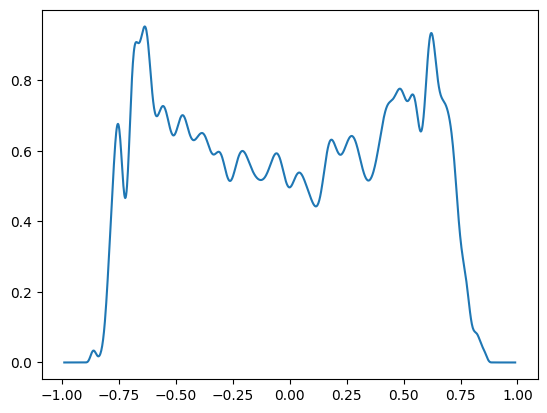

In [6]:
#plt.plot(np.linspace(-0.99, 0.99, 1000), exact_1D_dos(np.linspace(-0.99, 0.99, 1000)))
plt.plot(np.linspace(-0.99, 0.99, 1000), average_DOS(size, W_strenght, W_vector, 128, 50))

In [7]:
#STOCHASTIC LDOS

@njit
def get_random_vector_ldos(size):
    return np.exp(-2*np.pi*np.random.random(size)*1j).astype(np.cdouble)

@njit
def iterate_vector(E, M, r_init, W_vector, W_strenght):
    
    size = len(r_init)
    V = np.zeros(size).astype(np.cdouble)
    
    a = r_init
    b = hamiltonian_vector_product(r_init, W_vector, W_strenght)
    
    V += a*(1/(np.pi*np.sqrt(1 - E**2))) \
         *chebyshev_polynomial(E, 0)*jackson_kernel(M, 0)
    
    V += 2*b*(1/(np.pi*np.sqrt(1 - E**2))) \
          *chebyshev_polynomial(E, 1)*jackson_kernel(M, 1)
    
    for i in range (M - 2):
        
        c = 2*hamiltonian_vector_product(b, W_vector, W_strenght) - a
        V += 2*c*(1/(np.pi*np.sqrt(1 - E**2))) \
              *chebyshev_polynomial(E, i + 2)*jackson_kernel(M, i + 2)
        
        a = np.copy(b)
        b = np.copy(c)
        
    return r_init.conj()*V

@njit
def average_stochatistic_ldos(num_av, E, M, W_vector, W_strenght):
    
    size = len(W_vector)
    ldos_av = np.zeros(size).astype(np.cdouble)
    ldos_va = np.zeros(size).astype(np.cdouble)
    
    for i in range (num_av):
        r_init = get_random_vector_ldos(size)
        result_iter = iterate_vector(E, M, r_init, W_vector, W_strenght)
        
        ldos_av_old = ldos_av
        ldos_av += (result_iter - ldos_av)/(i + 1)
        ldos_va += ((result_iter.real - ldos_av_old.real)*(result_iter.real - ldos_av.real) - ldos_va.real)/(i + 1) \
              + 1j*((result_iter.imag - ldos_av_old.imag)*(result_iter.imag - ldos_av.imag) - ldos_va.imag)/(i + 1)
    
    return ldos_av, ldos_va

In [8]:
#EXACT LDOS

@njit
def get_position_vector(size, location):
    
    a = np.zeros(size)
    a[location] = 1
    
    return a.astype(np.cdouble)

@njit
def LDOS_position(E, M, size, location, W_vector, W_strenght):
    
    r_init = get_position_vector(size, location)
    
    moments = generate_moments(M, r_init, W_vector, W_strenght)
    LDOS = resum_moments(E, moments)
    
    return LDOS

@njit
def LDOS(E, M, size, W_vector, W_strenght):
    
    ldos = np.zeros(size).astype(np.cdouble)
    
    for i in range (size):
        ldos[i] = LDOS_position(E, M, size, i, W_vector, W_strenght)
        
    return ldos

In [9]:
%timeit LDOS_position(0, 1024, size, 2, W_vector, W_strenght)

9.71 ms ± 22.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
exact_ldos = LDOS(0, 1024, size, W_vector, W_strenght).real

In [11]:
stochastic = average_stochatistic_ldos(10000, 0, 1024, W_vector, W_strenght)

In [12]:
stochastic_ldos = stochastic[0].real
stochastic_var = stochastic[1]

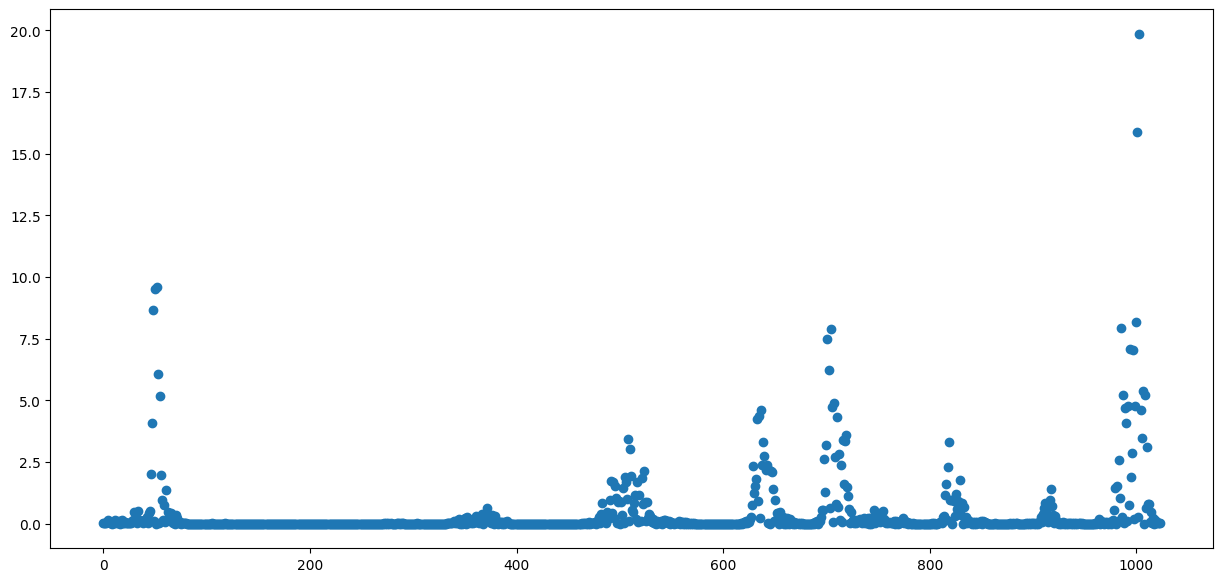

In [13]:
plt.figure(figsize=(15, 7))
plt.scatter(np.arange(0, size, 1), exact_ldos)

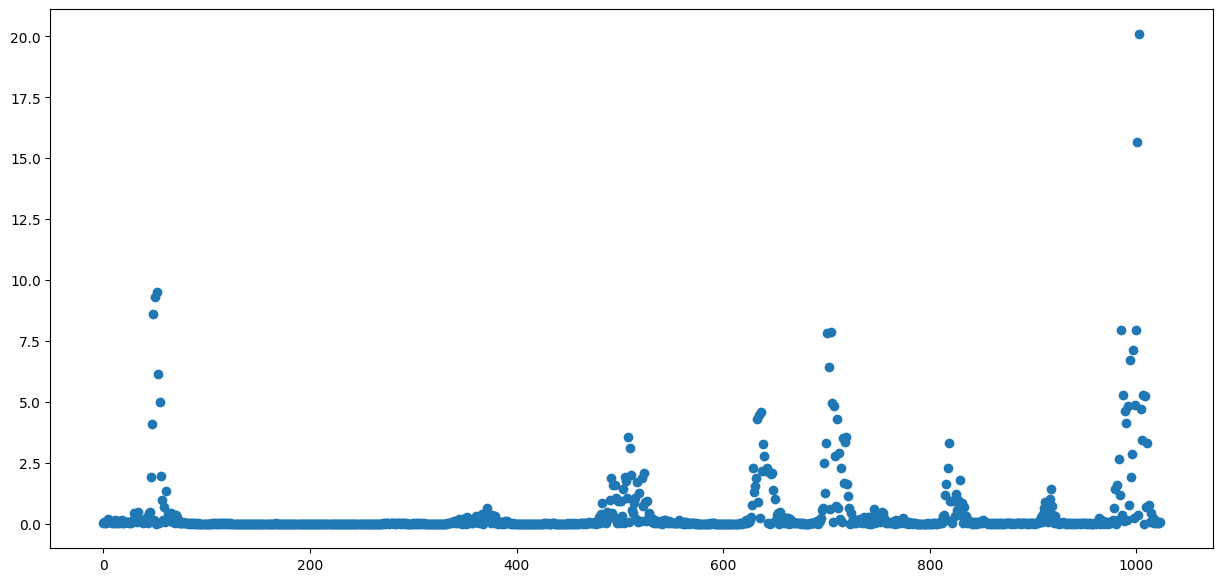

In [14]:
plt.figure(figsize=(15, 7))
plt.scatter(np.arange(0, size, 1), stochastic_ldos)

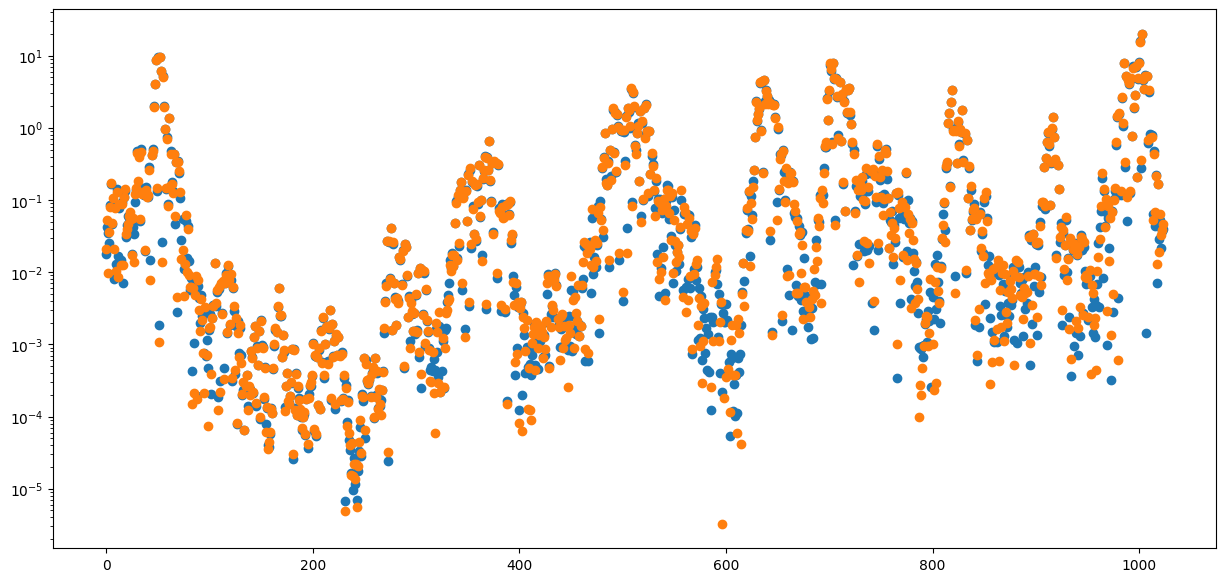

In [15]:
plt.figure(figsize=(15, 7))
plt.scatter(np.arange(0, size, 1), exact_ldos)
plt.scatter(np.arange(0, size, 1), stochastic_ldos)

plt.yscale("log")

In [16]:
@njit
def predicted_error(M, E, num_av, size, W_vector, W_strenght):
    
    higher_M = int(M*np.sqrt(2))
    width = np.pi/M
    
    ldos = LDOS(E, M, size, W_vector, W_strenght).real
    ldos_higher = LDOS(E, higher_M, size, W_vector, W_strenght).real
    
    error = ldos_higher/(2*np.pi*size*num_av*width) - ldos**2/num_av
    
    return error

In [17]:
error_pr = predicted_error(1024, 0, 10000, 1024, W_vector, W_strenght)

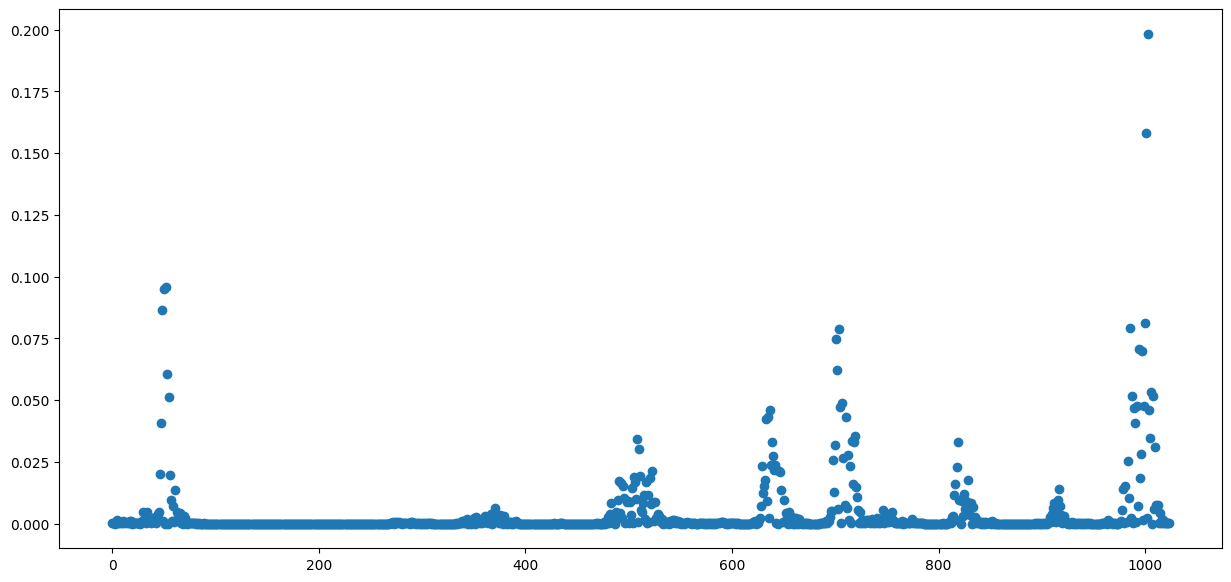

In [18]:
plt.figure(figsize=(15, 7))
plt.scatter(np.arange(0, size, 1), np.sqrt(abs(error_pr)))

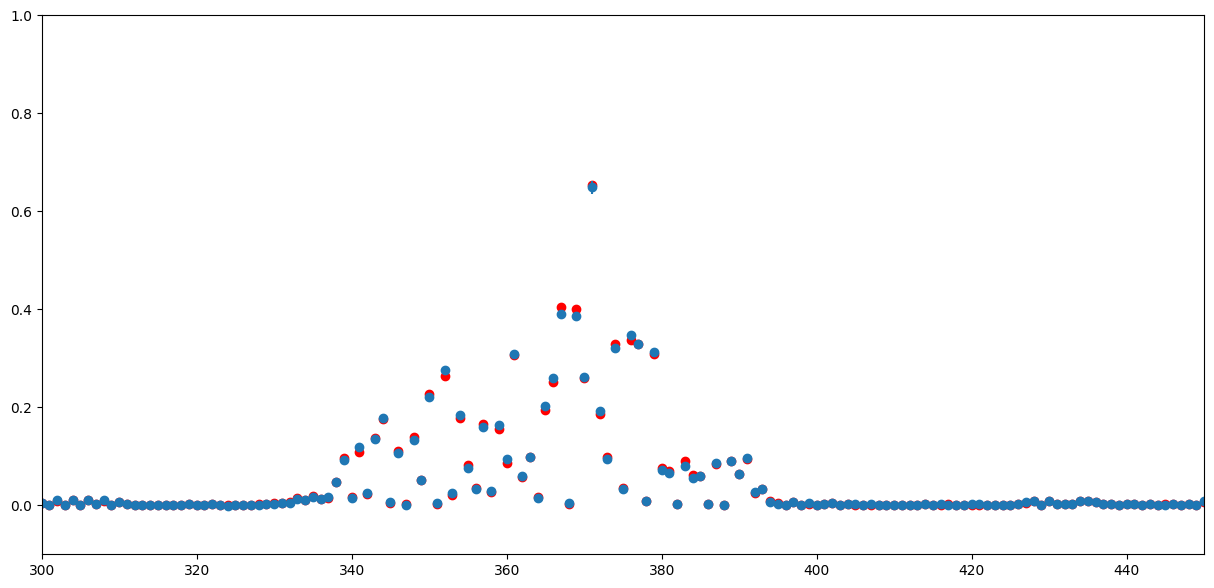

In [24]:
plt.figure(figsize=(15, 7))

plt.scatter(np.arange(0, size, 1), exact_ldos, c='red')
plt.errorbar(np.arange(0, size, 1), stochastic_ldos, yerr=2*np.sqrt(abs(error_pr)), fmt="o")

plt.ylim(top=1, bottom=-0.1)
plt.xlim(left = 300, right = 450)

#plt.yscale("log")
plt.show()

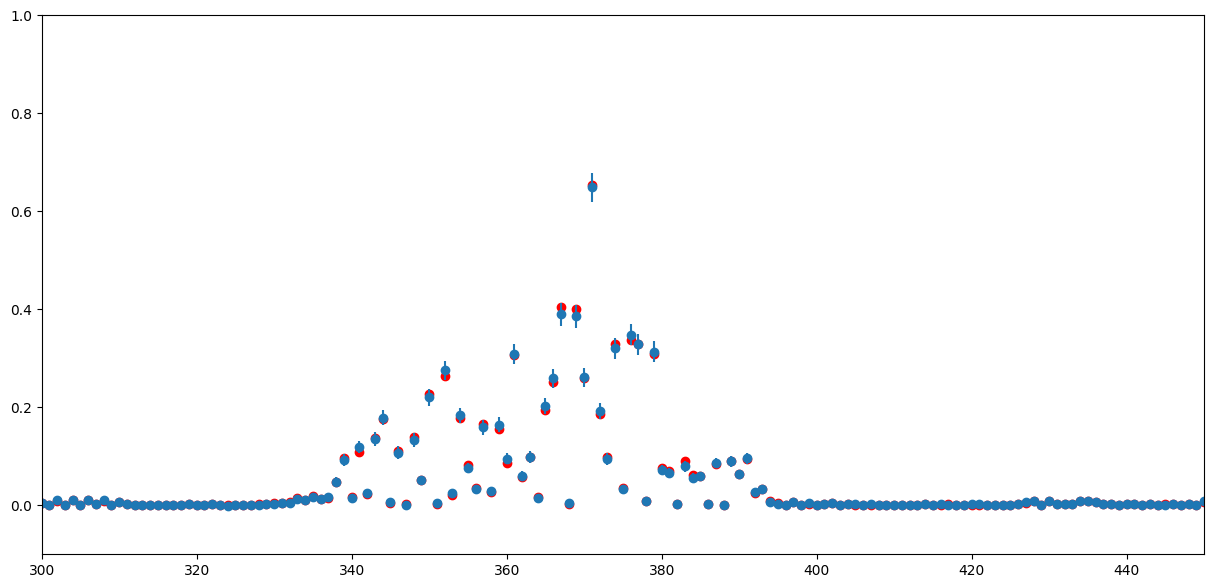

In [25]:
plt.figure(figsize=(15, 7))

plt.scatter(np.arange(0, size, 1), exact_ldos, c='red')
plt.errorbar(np.arange(0, size, 1), stochastic_ldos, yerr=2*np.sqrt(stochastic_var.real/10000), fmt="o")

plt.ylim(top=1, bottom=-0.1)
plt.xlim(left = 300, right = 450)
plt.show()

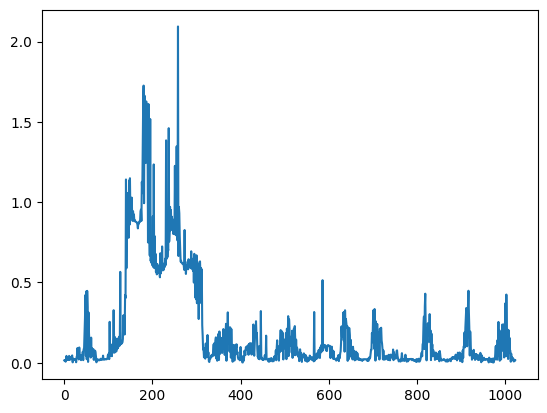

In [21]:
plt.plot(np.sqrt(abs(error_pr))/np.sqrt((stochastic_var.real + stochastic_var.imag)/10000))